# <font color="red">Creating Luminosity Functions of Brown Dwarf Candidates from GCNS Table</font>

Thesis work for Dylan Hilligoss

Importing relevant packages that allow for table read-in, value calculations, and plotting

In [1]:
import numpy as np
import astropy
import astroquery
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

Importing GCNS Catalogue from Vizier 

In [2]:
from astroquery.vizier import Vizier
catalog_list = Vizier.find_catalogs('GCNS')
print({k:v.description for k,v in catalog_list.items()})

{'J/A+A/649/A6': 'Gaia Catalogue of Nearby Stars - GCNS (Gaia collaboration, 2021)'}


Making sure the entirety of each table is read in and printing out each table in the catalogue.

In [3]:
Vizier.ROW_LIMIT = -1
catalogs = Vizier.get_catalogs(catalog_list.keys())
print(catalogs)

TableList with 8 tables:
	'0:J/A+A/649/A6/table1c' with 31 column(s) and 331312 row(s) 
	'1:J/A+A/649/A6/table1r' with 31 column(s) and 880428 row(s) 
	'2:J/A+A/649/A6/progwd' with 3 column(s) and 45 row(s) 
	'3:J/A+A/649/A6/table3' with 9 column(s) and 19176 row(s) 
	'4:J/A+A/649/A6/maglim' with 13 column(s) and 12288 row(s) 
	'5:J/A+A/649/A6/missing' with 9 column(s) and 1259 row(s) 
	'6:J/A+A/649/A6/hyacomb' with 4 column(s) and 1132 row(s) 
	'7:J/A+A/649/A6/distpdf' with 15 column(s) and 1211740 row(s) 


We are only interested in the first table "...table1c" so we pull that out and set it equal to variable "stellardata."

In [4]:
stellardata=catalogs['J/A+A/649/A6/table1c']

In [5]:
#whitedwarfs=catalogs['J/A+A/649/A6/progwd']

In [6]:
#stellardata

Of particular interest when calculating brown dwarf candidates is to look at their tangential velocities. Here we calculate these vtan velocities for each star in the set.

In [7]:
tangential_velocity=4.74*np.sqrt((stellardata['pmDE']/1000)**2+(stellardata['pmRA']/1000)**2)*(1000/stellardata['Plx'])
#Gives tangential velocity in km/s
#tangential_velocity

Here we calculate the absolute Gmag for each star in "stellardata"

In [8]:
abs_Gmag=stellardata['Gmag']-5*np.log((stellardata['Dist50']*1000)/10)
#abs_Gmag

And I add tangential velocity and absolute Gmag as additional columns to stellardata.

In [9]:
stellardata["Tangential Velocity"]=tangential_velocity
stellardata["Abs G Magnitude"]=abs_Gmag

In [10]:
#stellardata

Here I define G-RP and G-J color indicies so I can produce an HR-Diagram.

In [11]:
#Color Indices
stellardata["G-RP"]=stellardata['Gmag']-stellardata['RPmag']
stellardata["G-J"]=stellardata['Gmag']-stellardata['Jmag']

In [12]:
stellardata

GaiaEDR3,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Gmag,BPmag,RPmag,RV,Dist50,xcoord50,ycoord50,zcoord50,Uvel50,Vvel50,Wvel50,gmag,rmag,imag,zmag,Jmag,Hmag,Ksmag,W1mag,W2mag,W3mag,W4mag,GAIAEDR3Cat,_RA.icrs,_DE.icrs,Tangential Velocity,Abs G Magnitude,G-RP,G-J
,deg,deg,mas,mas / yr,mas / yr,mag,mag,mag,km / s,kpc,pc,pc,pc,km / s,km / s,km / s,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,deg,deg,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,bytes11,float64,float64,float64,float64,float64,float64
2334666126716440064,0.0025650,-26.3653495,14.697,23.497,-62.339,15.7779,17.4299,14.5407,--,0.06803,11.27021,7.54892,-66.66381,--,--,--,17.796,16.549,15.059,14.396,12.833,12.267,11.977,11.799,11.606,11.100,9.074,GAIAEDR3Cat,0.0024484,-26.3650724,21.486021907447356,6.191081543185383,1.2372000000000014,2.944899816894532
2341871673090078592,0.0051210,-19.4988406,26.798,179.805,-1.041,8.9429,9.4761,8.2513,--,0.03739,4.10140,8.09092,-36.27160,--,--,--,9.979,8.946,8.662,9.726,7.402,6.975,6.807,6.868,6.800,6.722,6.704,GAIAEDR3Cat,0.0042732,-19.4988360,31.80423851858622,2.348809020025116,0.6915999999999993,1.5409000495910643
530861741656374272,0.0056369,70.8873639,10.282,-52.864,17.787,10.8521,11.3022,10.2396,-26.204,0.09726,-46.21263,84.37781,14.27200,32.872,-13.707,8.930,--,--,--,--,9.523,9.079,9.007,8.965,9.024,8.937,8.649,GAIAEDR3Cat,0.0063545,70.8872848,25.712798252208,-0.5219135599079721,0.6125000000000007,1.3291002365112305
2745400068346761216,0.0093361,6.5110167,16.260,117.495,9.521,16.2772,18.2886,14.9456,--,0.06152,-6.73827,35.40890,-49.85672,--,--,--,18.661,17.399,15.571,14.717,12.922,12.312,12.031,11.866,11.660,11.630,8.881,GAIAEDR3Cat,0.0088105,6.5109744,34.36357961146171,7.193313838983288,1.3316,3.3552000686645513
2855176271335676800,0.0135364,29.2778958,10.295,51.287,46.282,15.6236,17.0649,14.4501,--,0.09716,-27.65700,77.35709,-51.86940,--,--,--,17.406,16.202,14.932,14.344,12.876,12.282,12.081,11.907,11.743,11.589,9.077,GAIAEDR3Cat,0.0132751,29.2776901,31.806764574470662,4.2547299443003705,1.1734999999999989,2.7475995956420896
4616265759236854016,0.0148925,-86.5417045,8.276,15.239,14.097,20.7053,21.4042,19.0972,--,0.11751,56.35943,-84.11356,-59.63383,--,--,--,--,--,--,--,16.323,15.729,15.282,15.021,14.847,13.058,9.303,GAIAEDR3Cat,0.0137697,-86.5417672,11.88974600299726,8.38560828324098,1.6081000000000003,4.382300045776368
2875125810310195712,0.0157909,34.1883005,20.194,-227.366,-56.934,8.3483,8.6769,7.8431,-29.942,0.04952,-15.72239,41.02444,-22.85814,61.074,-5.584,12.826,12.388,12.293,12.445,9.007,7.249,6.940,6.885,7.249,6.922,6.883,6.824,GAIAEDR3Cat,0.0170125,34.1885535,55.015819108460086,0.34934232308852575,0.5052000000000003,1.099299927520752
2335003848584711040,0.0159102,-25.4988391,12.613,-25.099,-17.494,14.6687,16.1144,13.4936,--,0.07931,12.57312,9.85767,-77.68060,--,--,--,16.457,15.264,13.971,13.404,11.925,11.293,11.037,10.926,10.774,10.602,8.804,GAIAEDR3Cat,0.0160338,-25.4987613,11.49735212397058,4.314804344494085,1.1750999999999987,2.743699809265136


Now I make subsets of stellar data with color index and absolute Gmag constraints which are an initial attempt to select brown dwarfs from the set.

In [13]:
GRPsubset=stellardata[(stellardata['G-RP']>1.0) & (stellardata['G-RP']<3.0) & (stellardata['Abs G Magnitude']>14.0)]
#GRPsubset

/Applications/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Applications/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [14]:
GJsubset=stellardata[(stellardata['G-J']>4.0) & (stellardata['G-J']<7.0) & (stellardata['Abs G Magnitude']>14.0)]
#GJsubset

The following is a histogram of absolute Gmag for the entire stellardata set.

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, '# of Objects')

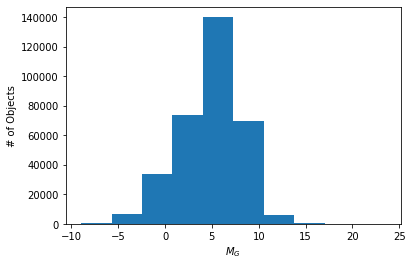

In [110]:
plt.hist(stellardata["Abs G Magnitude"])
plt.xlabel("$M_G$")
plt.ylabel("# of Objects")

The following plots are histograms of tangential velocities for the entire stellardata set followed by the two created subsets.

Text(0.5, 1.0, 'Tangential Velocity Distribution of GCNS')

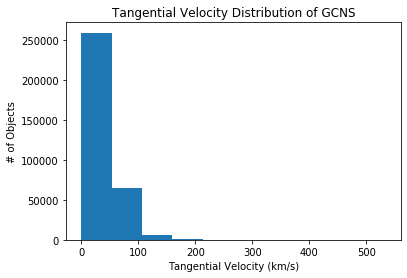

In [153]:
plt.hist(stellardata["Tangential Velocity"])
plt.xlabel("Tangential Velocity (km/s)")
plt.ylabel("# of Objects")
plt.title("Tangential Velocity Distribution of GCNS")
#plt.xlim(0,100)

This is for an approximate G-RP subset of stars.


Text(0.5, 1.0, 'Tangential Velocity Distribution of GCNS Brown Dwarfs')

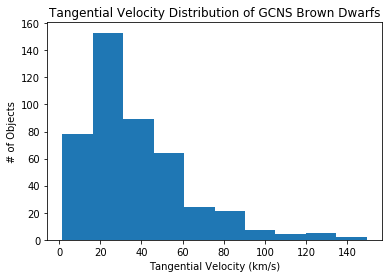

In [150]:
print("This is for an approximate G-RP subset of stars.")
plt.hist(GRPsubset['Tangential Velocity'])
plt.xlabel("Tangential Velocity (km/s)")
plt.ylabel("# of Objects")
plt.title("Tangential Velocity Distribution of GCNS Brown Dwarfs")

This is for an approximate G-J subset of stars.


Text(0, 0.5, '# of Objects')

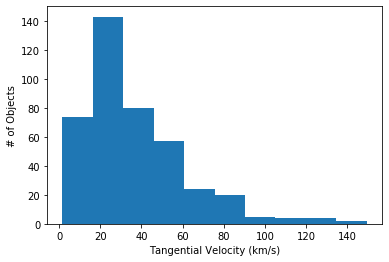

In [18]:
print("This is for an approximate G-J subset of stars.")
plt.hist(GJsubset['Tangential Velocity'])
plt.xlabel("Tangential Velocity (km/s)")
plt.ylabel("# of Objects")

Below is an HR-Diagram for stellardata using G-RP as a color index.

Text(0.5, 1.0, 'H-R Diagram of GCNS Dataset')

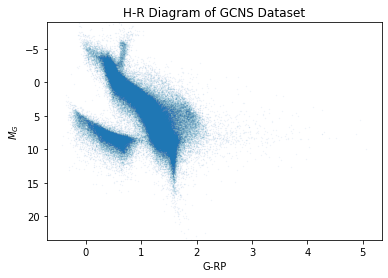

In [58]:
plt.scatter(stellardata['G-RP'],stellardata['Abs G Magnitude'],s=0.1,alpha=0.1)
plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlabel("G-RP")
plt.ylabel(r"$M_G$")
plt.title("H-R Diagram of GCNS Dataset")

Zooming in on the bottom tail of the HR-Diagram which corresponds to low-mass stars/potential brown dwarfs at the low end of the Main Sequence.

Text(0.5, 1.0, 'Zoomed H-R Diagram of GCNS Dataset')

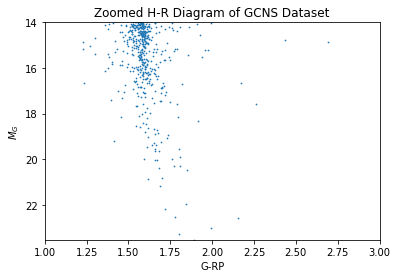

In [59]:
plt.scatter(stellardata['G-RP'],stellardata['Abs G Magnitude'],s=0.5)
#plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlim(1,3)
plt.ylim(max(stellardata['Abs G Magnitude']),14)
plt.xlabel("G-RP")
plt.ylabel(r"$M_G$")
plt.title("Zoomed H-R Diagram of GCNS Dataset")

Below is an HR-Diagram for stellardata using G-J as a color index.

Text(0, 0.5, 'Abs G Magnitude')

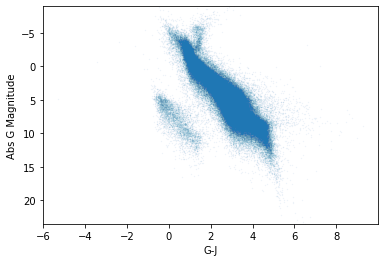

In [21]:
plt.scatter(stellardata['G-J'],stellardata['Abs G Magnitude'],s=0.1,alpha=0.1)
plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlabel("G-J")
plt.ylabel("Abs G Magnitude")

Zooming in on the bottom tail of the HR-Diagram which corresponds to low-mass stars/potential brown dwarfs at the low end of the Main Sequence.

Text(0, 0.5, 'Abs G Magnitude')

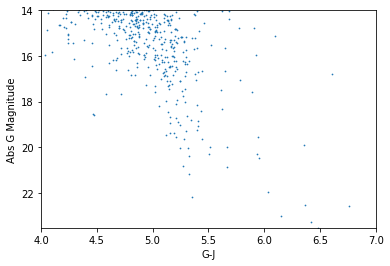

In [22]:
plt.scatter(stellardata['G-J'],stellardata['Abs G Magnitude'],s=0.5)
#plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlim(4,7)
plt.ylim(max(stellardata['Abs G Magnitude']),14)
plt.xlabel("G-J")
plt.ylabel("Abs G Magnitude")

Creating a subset of stellardata that focuses in on the Red Giant Branch (RGB). Then I plot a histogram of the tangential velocities of these objects. Finally I look at a zoomed in HR-Diagram of these RGB objects.

In [23]:
RGBsubset=stellardata[(stellardata['G-RP']>0.5) & (stellardata['G-RP']<1.0) & (stellardata['Abs G Magnitude']<-4.0)]

This is for an approximate RGB subset of stars.


Text(0, 0.5, '# of Objects')

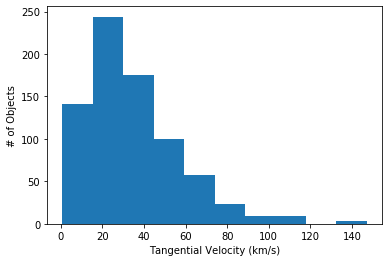

In [24]:
print("This is for an approximate RGB subset of stars.")
plt.hist(RGBsubset['Tangential Velocity'])
plt.xlabel("Tangential Velocity (km/s)")
plt.ylabel("# of Objects")

Text(0, 0.5, 'Abs G Magnitude')

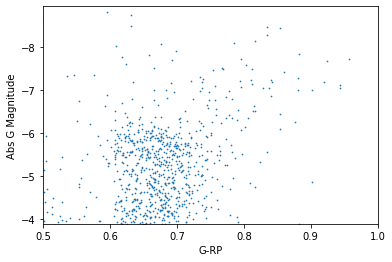

In [25]:
#RGB Set approx.
plt.scatter(stellardata['G-RP'],stellardata['Abs G Magnitude'],s=0.5)
#plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlim(0.5,1)
plt.ylim(-3.9,min(stellardata['Abs G Magnitude']))
plt.xlabel("G-RP")
plt.ylabel("Abs G Magnitude")

In [26]:
#RGBsubset

In order to ultimately find the luminosity function, I first calculate Vmax, or the maximum volume, as described in the *Gaia* Early Data Release 3: The *Gaia* Catalogue of Nearby Stars (GAIA Collaboration+ et al. 2020) arxiv#2012.02061 for further reference

The first thing to do is to find the galactic coordinates of each star in stellardata given the right ascensions and declinations.

In [27]:
c = SkyCoord(ra=stellardata["RA_ICRS"], dec=stellardata["DE_ICRS"], frame='icrs')
c

<SkyCoord (ICRS): (ra, dec) in deg
    [(2.56500000e-03, -26.3653495), (5.12100000e-03, -19.4988406),
     (5.63690000e-03,  70.8873639), ..., (3.59994771e+02, -53.1822876),
     (3.59995813e+02,  60.9183058), (3.59999926e+02, -30.0245287)]>

In [28]:
cgal=c.galactic
cgal
#cgal.size

<SkyCoord (Galactic): (l, b) in deg
    [( 33.81465884, -78.49844234), ( 63.11894944, -75.9590265 ),
     (118.70895672,   8.43836494), ..., (319.58451356, -62.25059824),
     (116.71800813,  -1.33113716), ( 15.52038568, -78.34899003)]>

In [29]:
#cgal.b

In [30]:
#Convert to radians.....
gal_latitude=cgal.b
#gal_latitude
#np.sin(np.abs(np.deg2rad(gal_latitude.value)))

Now explicitly calculating the absolute G magnitude from the Distance Modulus in preparation for calculating the luminosity function

In [31]:
#Adding absolute G Magnitude to stellardata in preparation for calculation of luminosity function.
dm=5.0*(np.log10(stellardata['Dist50']*1000/10))
absG=stellardata['Gmag']-dm

stellardata["absG"]=absG

Calculating values to be put in to equation for Vmax. Note that to calculate dmax, we capped off the maximum distance at 100pc due to *GAIA* limitations.

In [32]:
H=365
#d2=10*u.pc*(np.exp(absG-20.4/5))
dmax=10*10**((20.41-absG)/5)
dmax1=np.clip(dmax,0,100)
#dmax
sky_area=4*np.pi
#sky_area
ξ=(dmax1*np.sin(np.abs(np.deg2rad(gal_latitude)))/H)

Calculation of Vmax and adding it as a column to stellardata.

In [33]:
Vmax=sky_area*((H**3)/(np.sin(np.abs(np.deg2rad(gal_latitude))))**3)*(2-((ξ**2+(2*ξ)+2)*np.exp(-ξ)))
stellardata["Vmax"]=Vmax
#stellardata
#stellardata['Vmax']

Now I begin creating luminosity functions for the GCNS table and applying constraints to narrow down this set into a viable set of brown dwarf candidates.

In [34]:
####Creating an array which will be used to house our luminosity function data. From below, we create it to have a 
#length cooresponding to the number of absolute magnitude bins we selected.
lf_spacedensity=np.zeros(82)

In [198]:
#Creating 0.25 absolute G magnitude width bins, putting data into the correct bin, and counting number of data 
#points per bin.
bins=np.linspace(0.0,20.0,82)
bin_data=np.digitize(absG,bins)
bincount=np.bincount(bin_data)
#y_error0=np.zeros(69)

In [199]:
#Run a for loop to create array of luminosity function values for each absolute magnitude bin. AbsG magnitudes are
#constrained between 0 and 20
for n1 in range(absG.size):
    if ((absG[n1]>=0.0)and(absG[n1]<=20.0)):
            my_bin=bin_data[n1]
            lf_spacedensity[my_bin]+=1.0/Vmax[n1]
            bincount[my_bin]+=1
print(lf_spacedensity)
#y_error0=lf_spacedensity/np.sqrt(bincount)

[0.         0.00023501 0.00055149 0.00049484 0.00050036 0.00047525
 0.00056865 0.00069554 0.00092641 0.00113107 0.00147542 0.00171561
 0.00239011 0.00303999 0.00359802 0.00424268 0.00471126 0.00508494
 0.00538734 0.00596935 0.00623167 0.00684177 0.00711035 0.00711142
 0.00761383 0.00787233        inf        inf 0.00807002 0.0084307
 0.0087243  0.00930329 0.00991899 0.01074251 0.01191628 0.01326935
        inf 0.01646649        inf        inf 0.024119   0.02675409
 0.02787709 0.02918649        inf 0.02951683        inf        inf
 0.0264325  0.02445324        inf 0.02068601 0.01894826        inf
 0.01579727        inf 0.01395862 0.01387427        inf        inf
 0.01385252 0.0135704  0.01242254 0.01142795 0.00997193 0.00679112
 0.00557592 0.00488384 0.0048434  0.00442322 0.0038009  0.00308168
 0.00299588 0.00313162 0.00430909 0.00376962 0.00393786 0.00334731
 0.00371669 0.0018264  0.00295606 0.00209396]


Above we see that some values in the luminosity function are equal to infinity...Obviously something is off. So lets
look at where $V_{max}=0$ as the luminosity function is defined as $V_{max}=\Sigma\frac{1}{Vmax}$

In [200]:
bin_data[n1]
print(np.where(Vmax==0))

(array([ 88523,  99116, 113313, 126802, 141279]),)


So lets look at these specific data points within stellardata to see if we notice anything else unusual...

Found ξ to be of order 10^(-6) for Vmax[ 88523,  99116, 113313, 126802, 141279] indices. All other values were of
order 10^(-2). Seems that for some reason these values have extremely small galactic latitudes. Along galactic
equator, but not near galactic center. Related to GAIA limitations? Or Vmax equation seems to break down for 
galactic latitudes ~=0.

But moving on and deleting the infinity values within the luminosity function...

In [201]:
lf_spacedensity1=np.delete(lf_spacedensity,np.where(lf_spacedensity==np.inf))
bins1=np.linspace(0.0,20.0,69)

In [202]:
np.sum(lf_spacedensity1)/4

0.14528755737913007

In [203]:
lf_spacedensity1.size

69

Plot of luminosity function for GCNS sample of stars which have absolute G magnitudes between 0 and 20 broken up into
0.25 absolute magitude bins. This plot shows the luminosity function as a function of bin number.

Text(0.5, 1.0, 'GCNS Luminosity Function')

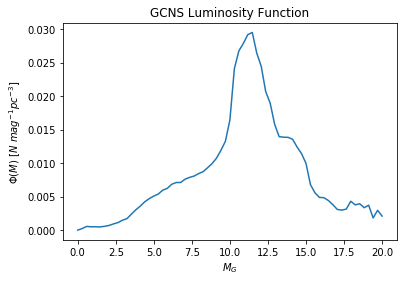

In [208]:
plt.plot(bins1,lf_spacedensity1)
plt.xlabel("$M_G$")
plt.ylabel('$\Phi(M)$ $[N$ $mag^{-1}  pc^{-3}]$')
plt.title("GCNS Luminosity Function")

Why are x limits so high? - Cooresponding to the # of Bins

What are implications of this luminosity function? - Brown Dwarfs lie on right hand side of plot. Around little "hump" and cliff. E.g. between x=55 and x=65 (roughly)

Now zooming in on the luminosity function where the "hump" is located... i.e. 50<x<70

Text(0.5, 1.0, 'Zoomed Luminosity Function with AbsG Constraints')

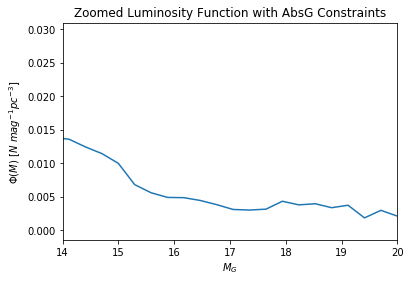

In [209]:
plt.plot(bins1,lf_spacedensity1)
plt.xlim(14,20)
plt.xlabel("$M_G$")
plt.ylabel('$\Phi(M)$ $[N$ $mag^{-1}  pc^{-3}]$')
plt.title("Zoomed Luminosity Function with AbsG Constraints")

Now creating and plotting the luminosity function with the added constraint that Tangential Velocity>=100.0km/s 
(gives us information about stellar age)

In [210]:
bins2=np.linspace(0,20,82)
lf_spacedensity2=np.zeros(82)
for n2 in range(absG.size):
    if ((absG[n2]>=0.0)and(absG[n2]<=20.0)and(tangential_velocity[n2]>=100.0)):
            my_bin=bin_data[n2]
            lf_spacedensity2[my_bin]+=1.0/Vmax[n2]
print(lf_spacedensity2)

[0.00000000e+00 0.00000000e+00 8.35820220e-07 1.31201521e-06
 2.58851766e-07 0.00000000e+00 5.70249411e-07 0.00000000e+00
 2.40557948e-07 5.50009057e-07 1.02385946e-06 1.35092642e-06
 1.94823564e-06 2.12819367e-06 2.62671748e-06 5.63311892e-06
 9.86937236e-06 1.23685453e-05 1.16955924e-05 1.89834838e-05
 1.77919520e-05 1.46062739e-05 1.73859555e-05 1.91923166e-05
 2.08251872e-05 2.39524058e-05 1.96729169e-05 2.21445474e-05
 2.34177266e-05 2.40338284e-05 2.57307403e-05 2.47944963e-05
 2.40115912e-05 2.71881658e-05 3.35802199e-05 4.31637904e-05
 5.18428601e-05 5.66390973e-05 6.95951623e-05 6.55355582e-05
 8.13241038e-05 9.32608167e-05 9.63904493e-05 9.51019512e-05
 1.03699176e-04 1.03338354e-04 1.05369618e-04 9.22413448e-05
 9.52239999e-05 8.96968753e-05 8.29314635e-05 8.14711767e-05
 7.10605122e-05 6.09284221e-05 5.33804758e-05 5.48709860e-05
 4.88454193e-05 5.29279325e-05 4.91800732e-05 4.94549762e-05
 6.01674324e-05 7.23795147e-05 8.16559685e-05 8.18072212e-05
 7.30801846e-05 3.939150

Text(0.5, 1.0, 'Luminosity Function with AbsG and Tangential Velocity Constraints')

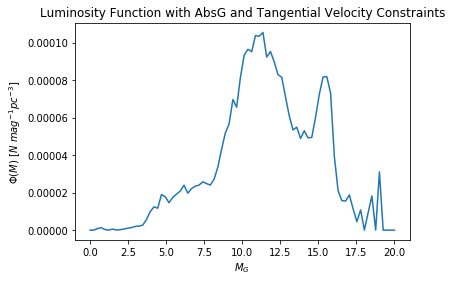

In [211]:
plt.plot(bins2,lf_spacedensity2)
plt.xlabel("$M_G$")
plt.ylabel('$\Phi(M)$ $[N$ $mag^{-1}  pc^{-3}]$')
plt.title("Luminosity Function with AbsG and Tangential Velocity Constraints")

Now creating and plotting the luminosity function with the added constraint that AbsG>14.0, AbsG<20.0,
Tangential Velocity>=100.0km/s, G-RP>1.0 and G-RP<3.0. This time, we the x axis is in terms of absG magnitude rather than bin number so it makes more physical sense.

I've also added error bars corresponding to each data point. $error=\frac{Luminosity Function}{\sqrt{n}}$

In [212]:
bins1=np.linspace(14.0,20.0,25)
bin_data1=np.digitize(absG,bins1)
bincount1=np.zeros(25)
lf_spacedensity3=np.zeros(25)
y_error=np.zeros(25)
for n3 in range(absG.size):
    if ((absG[n3]>=14.0)and(absG[n3]<=20.0)and(tangential_velocity[n3]>=100.0)and(stellardata['G-RP'][n3]>=1.0)and(stellardata['G-RP'][n3]<=3.0)):
            my_bin=bin_data1[n3]
            lf_spacedensity3[my_bin]+=1.0/Vmax[n3]
            bincount1[my_bin]+=1
#print(lf_spacedensity3)
y_error=lf_spacedensity3/np.sqrt(bincount1)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [213]:
np.sum(lf_spacedensity3)/4

9.349072340156691e-05

Potential Luminosity Function of Brown Dwarf Candidates, High Vtan $V_{tan}>=100\frac{km}{s}$ with absG and color index constraints.

Text(0.5, 1.0, 'Luminosity Function of Fast Moving Brown Dwarfs')

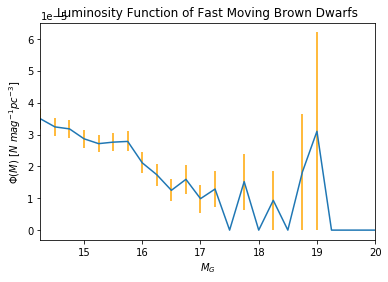

In [214]:
plt.errorbar(bins1, lf_spacedensity3,yerr=y_error,ecolor='orange')
plt.xlabel(r"$M_G$")
plt.ylabel('$\Phi(M)$ $[N$ $mag^{-1}  pc^{-3}]$')
plt.xlim(bins1[1],np.max(bins1))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("Luminosity Function of Fast Moving Brown Dwarfs")

In [215]:
bincount1

array([  0., 131., 121., 119., 107., 102., 101.,  78.,  42.,  26.,  13.,
        12.,   5.,   5.,   0.,   3.,   0.,   1.,   0.,   1.,   1.,   0.,
         0.,   0.,   0.])

Potential Luminosity Function of Brown Dwarf Candidates, Low Vtan $V_{tan}<=20\frac{km}{s}$ while keeping all other absG and color index constraints the same as before.

In [216]:
#Low Vtan BD Candidates
bins2=np.linspace(14.0,20.0,25)
bin_data2=np.digitize(absG,bins2)
bincount2=np.zeros(25)
lf_spacedensity4=np.zeros(25)
y_error1=np.zeros(25)
for n4 in range(absG.size):
    if ((absG[n4]>=14.0)and(absG[n4]<=20.0)and(tangential_velocity[n4]<=20.0)and(stellardata['G-RP'][n4]>=1.0)and(stellardata['G-RP'][n4]<=3.0)):
            my_bin=bin_data2[n4]
            lf_spacedensity4[my_bin]+=1.0/Vmax[n4]
            bincount2[my_bin]+=1
#print(lf_spacedensity4)
y_error1=lf_spacedensity4/np.sqrt(bincount2)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [217]:
np.sum(lf_spacedensity4)/4

0.0010259337816981918

In [218]:
lf_spacedensity3

array([0.00000000e+00, 3.49512279e-05, 3.24039576e-05, 3.17798876e-05,
       2.86662816e-05, 2.71456453e-05, 2.76167342e-05, 2.78455625e-05,
       2.11181901e-05, 1.73774466e-05, 1.24939608e-05, 1.59401070e-05,
       9.86982632e-06, 1.28945643e-05, 0.00000000e+00, 1.52351080e-05,
       0.00000000e+00, 9.35203557e-06, 0.00000000e+00, 1.82457219e-05,
       3.10266364e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

Plotting Potential BD Candidates (with error) for Low Vtan $V_{tan}<=20\frac{km}{s}$ with absG and color index constraints.

Text(0.5, 1.0, 'Luminosity Function of Slow Moving Brown Dwarfs')

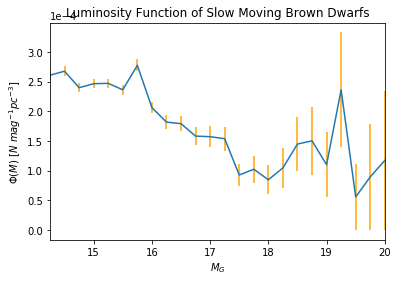

In [219]:
#Potential BD Candidates, Low Vtan
#plt.errorbar(bins1, 8*lf_spacedensity3,c="red", yerr=y_error,ecolor='orange')
plt.errorbar(bins2,lf_spacedensity4,y_error1,ecolor='orange')
plt.xlabel("$M_G$")
plt.ylabel('$\Phi(M)$ $[N$ $mag^{-1}  pc^{-3}]$')
plt.xlim(bins2[1],np.max(bins2))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("Luminosity Function of Slow Moving Brown Dwarfs")

In [220]:
lf_spacedensity4

array([0.00000000e+00, 2.60938495e-04, 2.67699917e-04, 2.39859041e-04,
       2.46607753e-04, 2.47221257e-04, 2.36383443e-04, 2.77619712e-04,
       2.06452436e-04, 1.81951727e-04, 1.79326506e-04, 1.58354048e-04,
       1.57380261e-04, 1.53931737e-04, 9.29112545e-05, 1.02507424e-04,
       8.48103809e-05, 1.04823682e-04, 1.45003468e-04, 1.50373823e-04,
       1.10214422e-04, 2.36443920e-04, 5.58308423e-05, 8.96826731e-05,
       1.17406902e-04])

Overplotted Luminosity Function of both slow and fast moving brown dwarfs. The fast moving brown dwarf luminosity function has been normalized by multiplying by 8.6. This has been normalized by dividing lf_spacedensity4 at $M_G$=15 by lf_spacedensity3 at $M_G$=15. i.e. $.000247/.0000287=8.6$

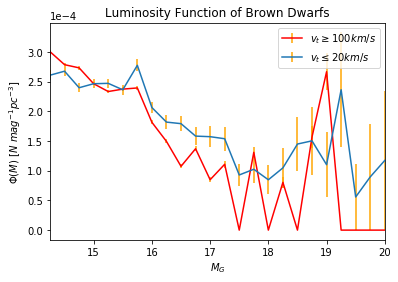

In [223]:
plt.errorbar(bins1, 8.6*lf_spacedensity3,c="red", yerr=y_error,ecolor='orange',label=r"$v_t\geq100km/s$")
plt.errorbar(bins2,lf_spacedensity4,y_error1,ecolor='orange',label=r"$v_t\leq20km/s$")
plt.xlabel("$M_G$")
plt.ylabel('$\Phi(M)$ $[N$ $mag^{-1}  pc^{-3}]$')
plt.xlim(bins2[1],np.max(bins2))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("Luminosity Function of Brown Dwarfs")
plt.legend(loc='best')

Creating a HR-Diagram only using the stars that have tangential velocities $V_{tan}>=100\frac{km}{s}$.

Text(0, 0.5, '$M_G$')

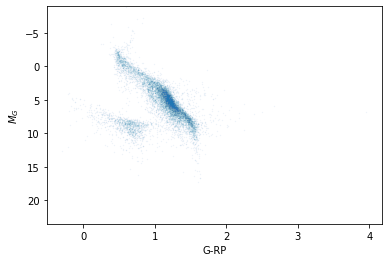

In [224]:
ihigh=np.where(tangential_velocity>=100.0)
plt.scatter(stellardata['G-RP'][ihigh],stellardata['Abs G Magnitude'][ihigh],s=0.1,alpha=0.1)
plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlabel("G-RP")
plt.ylabel("$M_G$")